In [1]:
import numpy as np

In [2]:
def norm_points(points, high=None, low=None):
    if high is None:
        high = np.max(points)
    if low is None:
        low = np.min(points)
    return (points-low)/float(high - low)

def cor(x, x_prime, delta):
    return np.exp(-np.power((x-x_prime)/delta, 2))

def cov(x, x_prime, delta, sigma_squared):
    return sigma_squared*cor(x, x_prime, delta)

def pi_star_delta(sigma_hat_sq, n, q, A_inv, A, H):
    return np.power(sigma_hat_sq, -(n-q)/2.)*np.power(np.linalg.det(A), -1/2.)*np.power(np.linalg.det(H.T.dot(A_inv).dot(H)), -1/2.)

def sigma_hat_sq(n, q, f_D, A_inv, H):
    res = np.power(n-q-2, -1.)
    res *= f_D.T.dot(A_inv-A_inv.dot(H).dot((H.T.dot(A_inv).dot(H)).getI()).dot(H.T).dot(A_inv))
    return res.dot(f_D)

def sigma_hat_sq_beta(n, q, f_D, A_inv, H_, beta_hat):
    return ((f_D-H_.dot(beta_hat)).T.dot(A_inv).dot(f_D-H_.dot(beta_hat)))/(n-q-2.)

def A(points, delta):
    return cor(points[:,np.newaxis], points, delta)

def tau(delta):
    return 2*np.log(delta)

def pi_star_tau(tau, n, q, f_D, A_inv, A, H):
    return pi_star_delta(sigma_hat_sq(n, q, f_D, A_inv, H), n, q, A_inv, A, H)

def H(x, h):
    return h(x).T

def beta_hat(H, A_inv, f_D):
    return (H.T.dot(A_inv).dot(H)).getI().dot(H.T).dot(A_inv).dot(f_D)

def h(x):
    return np.vstack((np.ones(len(x)), x))

def mahalanobis(f_D, m_star, v_star):
    return (f_D - m_star).T.dot(v_star.getI()).dot(f_D - m_star)

def se(f_D, m_star, v_star):
    return (f_D - m_star).T / np.sqrt(np.diag(v_star))

def make_t(D, delta_hat):
    def f(x):
        return cor(D[:,np.newaxis], x, delta_hat)
    return f

def make_m_star(h, b_hat, A_inv, f_D, t):
    def f(x):
        return h(x).T.dot(b_hat) + t(x).T.dot(A_inv).dot(f_D - H_.dot(b_hat))
    return f

def make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t):    
    def f(x, x_prime):
        return d_hat_sq*(cor(x[:,np.newaxis], x_prime, delta_hat) - t(x).T.dot(np.array(A_inv)).dot(t(x_prime)) + (h(x).T-t(x).T.dot(A_inv).dot(H_)).dot(H_.T.dot(A_inv.dot(H_)).getI()).dot((h(x_prime).T-t(x_prime).T.dot(A_inv.dot(H_))).T))
    return f


In [3]:
points = np.array([1100,1140,1180,1220,1260,1300])
f_D = np.array([[-48.85,-45.15,-23.78,-8.87,-1.49,4.77]]).T
D = norm_points(points)
taus = np.linspace(-6, 2)
n = len(points)
p = 1
q = 1 + p
delta_hat = 0.252

In [7]:
As = map(lambda s: A(D, np.exp(s/2.)), taus)
H(D, h), As[0]

(array([[ 1. ,  0. ],
        [ 1. ,  0.2],
        [ 1. ,  0.4],
        [ 1. ,  0.6],
        [ 1. ,  0.8],
        [ 1. ,  1. ]]),
 array([[  1.00000000e+000,   9.81124331e-008,   9.26608294e-029,
           8.42396226e-064,   7.37198992e-113,   6.21013649e-176],
        [  9.81124331e-008,   1.00000000e+000,   9.81124331e-008,
           9.26608294e-029,   8.42396226e-064,   7.37198992e-113],
        [  9.26608294e-029,   9.81124331e-008,   1.00000000e+000,
           9.81124331e-008,   9.26608294e-029,   8.42396226e-064],
        [  8.42396226e-064,   9.26608294e-029,   9.81124331e-008,
           1.00000000e+000,   9.81124331e-008,   9.26608294e-029],
        [  7.37198992e-113,   8.42396226e-064,   9.26608294e-029,
           9.81124331e-008,   1.00000000e+000,   9.81124331e-008],
        [  6.21013649e-176,   7.37198992e-113,   8.42396226e-064,
           9.26608294e-029,   9.81124331e-008,   1.00000000e+000]]))

In [5]:
A_invs = map(lambda a: np.matrix(a).getI(), As)

In [6]:
ln_pi_tau_star_pi = np.array(map(lambda (t, a_inv, a): np.log(pi_star_tau(np.exp(t/2.), n, q, f_D, a_inv, a, H(D, h))), zip(taus, A_invs, As))).flatten()

In [7]:
%matplotlib inline

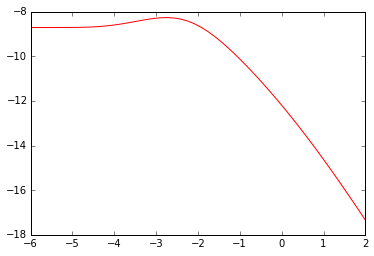

In [8]:
from pylab import *
figure()
plot(taus, ln_pi_tau_star_pi, 'r')
show()

In [9]:
from scipy.optimize import minimize

def f(x):
    a = A(D, np.exp(x/2.))
    a_inv = np.matrix(a).getI()
    return -np.log(pi_star_tau(np.exp(x/2.), n, q, f_D, a_inv, a, H(D, h)))

delta_hat = np.exp(minimize(f, -2.75, method="nelder-mead", options={'disp':True})['x']/2.)
print delta_hat

Optimization terminated successfully.
         Current function value: 8.268213
         Iterations: 12
         Function evaluations: 24
[ 0.25205994]


In [10]:
A_inv = np.matrix(A(D, delta_hat)).getI()
b_hat = beta_hat(H(D, h), A_inv, f_D)
d_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))[0,0]
H_ = H(D, h)

In [11]:
b_hat, d_hat_sq, sigma_hat_sq_beta(n, q, f_D, A_inv, H(D, h), b_hat)

(matrix([[-47.29520149],
         [ 53.78152555]]), 93.018516528847584, matrix([[ 93.01851653]]))

In [12]:
original_points = points
points = np.linspace(1075, 1325, 100)
normed_points = norm_points(points, high=1300, low=1100)

t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t)

In [13]:
predictions = np.array(m_star(normed_points)).flatten()
sds = np.sqrt(np.diag(v_star(normed_points, normed_points))).flatten()*2

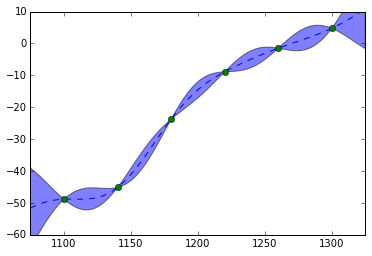

In [14]:
figure()
fill_between(points, predictions + sds, predictions - sds, alpha=0.5)
plot(points, predictions, '--')
plot(original_points, f_D.flatten(), 'o')
ylim([-60, 10])
xlim([1075, 1325])
show()

In [15]:
validation_points = np.array([1110, 1160, 1250])
D_prime = norm_points(validation_points, low=1100, high=1300)
print D_prime
f_D_prime = np.array([[-48.16, -39.63, -3.14]]).T
m_star_D_prime = m_star(D_prime)
print m_star_D_prime
v_star_D_prime = v_star(D_prime, D_prime)
print np.sqrt(np.diag(v_star_D_prime))
print se(f_D_prime, m_star_D_prime, v_star_D_prime)

[ 0.05  0.3   0.75]
[[-48.83531431]
 [-35.67297798]
 [ -3.10907137]]
[ 1.37927021  1.33280241  0.97486423]
[[ 0.48961712 -2.96894873 -0.03172609]]


In [16]:
mahalanobis(f_D_prime, m_star_D_prime, v_star_D_prime)

matrix([[ 26.66278627]])

In [17]:
points = np.array([1100, 1110, 1140, 1160, 1180,1220, 1250,1260,1300])
f_D = np.array([[-48.85,-48.16, -45.15, -39.63, -23.78,-8.87, -3.14, -1.49,4.77]]).T
D = norm_points(points)
n = len(points)

In [18]:
def f(x):
    a = A(D, np.exp(x/2.))
    a_inv = np.matrix(a).getI()
    return -np.log(pi_star_tau(np.exp(x/2.), n, q, f_D, a_inv, a, H(D, h)))

delta_hat = np.exp(minimize(f, -2.75, method="nelder-mead", options={'disp':True})['x']/2.)
print delta_hat

Optimization terminated successfully.
         Current function value: 10.658584
         Iterations: 15
         Function evaluations: 30
[ 0.16912901]


In [19]:
A_inv = np.matrix(A(D, delta_hat)).getI()
b_hat = beta_hat(H(D, h), A_inv, f_D)
d_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))[0,0]
H_ = H(D, h)
print b_hat, d_hat_sq

[[-48.64571544]
 [ 56.46321088]] 49.9993413295


In [20]:
original_points = points
points = np.linspace(1075, 1325,100)
normed_points = norm_points(points, high=1300, low=1100)

t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t)

predictions = np.array(m_star(normed_points)).flatten()
sds = np.sqrt(np.diag(v_star(normed_points, normed_points))).flatten()*2

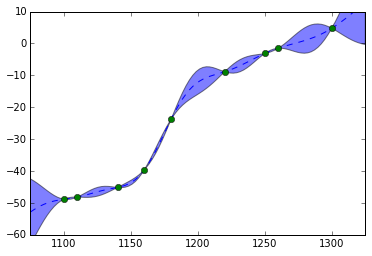

In [21]:
figure()
fill_between(points, predictions + sds, predictions - sds, alpha=0.5)
plot(points, predictions, '--')
plot(original_points, f_D.flatten(), 'o')
ylim([-60, 10])
xlim([1075, 1325])
show()

In [22]:
validation_points = np.array([1130, 1200, 1270])
D_prime = norm_points(validation_points, low=1100, high=1300)
print D_prime
f_D_prime = np.array([[-46.42, -15.45, 0.55]]).T
m_star_D_prime = m_star(D_prime)
print m_star_D_prime
v_star_D_prime = v_star(D_prime, D_prime)
print np.sqrt(np.diag(v_star_D_prime))
print se(f_D_prime, m_star_D_prime, v_star_D_prime)

[ 0.15  0.5   0.85]
[[-45.98899864]
 [-12.14907801]
 [ -0.23414354]]
[ 0.59568892  1.89344198  0.99100165]
[[-0.72353429 -1.74334467  0.79126361]]


In [23]:
mahalanobis(f_D_prime, m_star_D_prime, v_star_D_prime)

matrix([[ 6.20778753]])

Optimization terminated successfully.
         Current function value: 10.831993
         Iterations: 16
         Function evaluations: 32
[ 0.14505538]
[[-50.17996504]
 [ 58.64061095]] 30.060133767


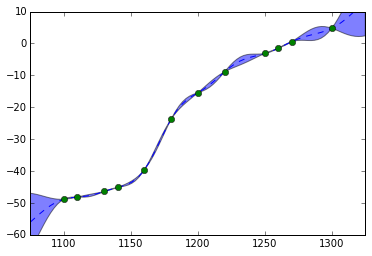

In [24]:
points = np.array([1100, 1110, 1130, 1140, 1160, 1180,1200, 1220, 1250,1260, 1270, 1300])
f_D = np.array([[-48.85,-48.16, -46.42, -45.15, -39.63, -23.78,-15.45, -8.87, -3.14, -1.49, 0.55, 4.77]]).T
D = norm_points(points)
n = len(points)
def f(x):
    a = A(D, np.exp(x/2.))
    a_inv = np.matrix(a).getI()
    return -np.log(pi_star_tau(np.exp(x/2.), n, q, f_D, a_inv, a, H(D, h)))

delta_hat = np.exp(minimize(f, -2.75, method="nelder-mead", options={'disp':True})['x']/2.)
print delta_hat
A_inv = np.matrix(A(D, delta_hat)).getI()
b_hat = beta_hat(H(D, h), A_inv, f_D)
d_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))[0,0]
H_ = H(D, h)
print b_hat, d_hat_sq
original_points = points
points = np.linspace(1075, 1325,100)
normed_points = norm_points(points, high=1300, low=1100)

t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t)

predictions = np.array(m_star(normed_points)).flatten()
sds = np.sqrt(np.diag(v_star(normed_points, normed_points))).flatten()*2
figure()
fill_between(points, predictions + sds, predictions - sds, alpha=0.5)
plot(points, predictions, '--')
plot(original_points, f_D.flatten(), 'o')
ylim([-60, 10])
xlim([1075, 1325])
show()